In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import numpy as np
import matplotlib as mpl
import os
from lmfit import minimize, Minimizer, Parameters, Parameter, report_fit, Model
from scipy.signal import savgol_filter

## Funções dos modelos (focar no Maxwell)

In [2]:
def oldroydB_elast(w, Gn0, tau_r):
    return Gn0 * w ** 2 * tau_r ** 2 / (1 + w ** 2 * tau_r ** 2)  

def oldroydB_visc(w, Gn0, tau_r, eta_inf):
    return Gn0 * w * tau_r / (1 + w ** 2 * tau_r ** 2) + eta_inf * w    # correto! Tese Calabrese

###############################

def jeffreys_elast(w, eta0, lambda1, lambda2):
    return eta0 * (lambda1 - lambda2) * w ** 2 / (1 + lambda1 ** 2 * w ** 2)
    
    
def jeffreys_visc(w, eta0, lambda1, lambda2):
    return eta0 * (1 + lambda1 * lambda2 * w ** 2) * w / (1 + lambda1 ** 2 * w ** 2)

###############################

def jeffreys_elast2(w, G0, lambda0, lambdaj):
    return ((G0 * lambda0 * (lambda0 - lambdaj) * w ** 2 
           / (1 + lambda0 ** 2 * w ** 2)))
    
    
def jeffreys_visc2(w, G0, lambda0, lambdaj):
    return (G0 * lambda0 * (1 + lambda0 * lambdaj * w ** 2) 
                        * w / (1 + lambda0 ** 2 * w ** 2))
    
###############################

def two_mode_elast(w, G01, G02, lambda1, lambda2):
    return (( G01 * (lambda1 * w) ** 2 / (1 + (lambda1 * w) ** 2) ) 
         + ( G02 * (lambda2 * w) ** 2 / (1 + (lambda2 * w) ** 2) ))
    
def two_mode_visc(w, G01, G02, lambda1, lambda2):
    return (( G01 * (lambda1 * w) / (1 + (lambda1 * w) ** 2) ) 
         + ( G02 * (lambda2 * w) / (1 + (lambda2 * w) ** 2) ))
    
###############################
def maxwell_elast(w, G0, lambda1):
    return G0 * (lambda1 * w) ** 2 / (1 + (lambda1 * w) ** 2)
    
def maxwell_visc(w, G0, lambda1):
    return G0 * (lambda1 * w)      / (1 + (lambda1 * w) ** 2)

In [3]:
# Simplificando os parâmetros, removendo os parâmetros possivelmente supérfluos
def residual(params, x, datasets):
    model_elast = maxwell_elast(x, params['G0'], params['tr'])
    model_visc  = maxwell_visc (x, params['G0'], params['tr'])
    
    resid1 = datasets[0] - model_elast
    resid2 = datasets[1] - model_visc
    return np.concatenate((resid1, resid2))

def residual_oldroyd(params, x, datasets):
    model_elast = oldroydB_elast(x, params['G0'], params['tr'])
    model_visc  = oldroydB_visc(x, params['G0'], params['tr'], params['eta_inf'])
    
    resid1 = datasets[0] - model_elast
    resid2 = datasets[1] - model_visc
    return np.concatenate((resid1, resid2))

def residual_log(params, x, datasets):
    model_elast = np.log10(maxwell_elast(x, params['G0'], params['tr']))
    model_visc  = np.log10(maxwell_visc (x, params['G0'], params['tr']))
    
    resid1 = np.log10(datasets[0]) - model_elast
    resid2 = np.log10(datasets[1]) - model_visc
    return np.concatenate((resid1, resid2))

def residual_oldroyd_log(params, x, datasets):
    model_elast = np.log10(oldroydB_elast(x, params['G0'], params['tr']))
    model_visc  = np.log10(oldroydB_visc(x, params['G0'], params['tr'], params['eta_inf']))
    
    resid1 = np.log10(datasets[0]) - model_elast
    resid2 = np.log10(datasets[1]) - model_visc
    return np.concatenate((resid1, resid2))

def residual_jeffreys(params, x, datasets):
    jeff_elast = jeffreys_elast2(x, params['G0'], params['lambda1'], params['lambda2'])
    jeff_visc  = jeffreys_visc2 (x, params['G0'], params['lambda1'], params['lambda2'])

    resid1 = datasets[0] - jeff_elast
    resid2 = datasets[1] - jeff_visc
    return np.concatenate((resid1, resid2))

def residual_two_mode(params, x, datasets):
    tm_elast = two_mode_elast(x, params['G0_1'], params['G0_2'], params['lambda1'], params['lambda2'])
    tm_visc  = two_mode_visc (x, params['G0_1'], params['G0_2'], params['lambda1'], params['lambda2'])

    resid1 = datasets[0] - tm_elast
    resid2 = datasets[1] - tm_visc
    return np.concatenate((resid1, resid2))

## Testando com uma curva

In [11]:
files = glob.glob('OF_Agua1--0.csv')
files_pd = []
for file in files:
    temp_pd = pd.read_csv(file, encoding='utf8', delimiter=';', decimal=',')
    files_pd.append(temp_pd)

file = files_pd[0]
file.head()

,Agua1 w,Agua1 G1,Agua1 G2,Agua1 T
0,0.006283,12.95,18.66,24.99
1,0.007406,16.09,20.17,24.99
2,0.008730,18.76,21.01,24.97
3,0.010290,22.09,21.74,25.00
4,0.012130,25.90,22.27,25.00


Text(0,0.5,"Módulos G', G''/Pa")

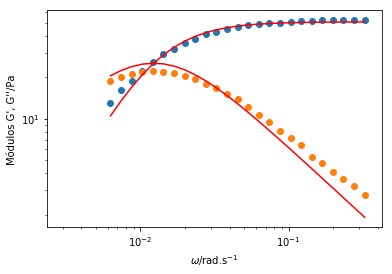

In [5]:
params = Parameters()
params.add('G0',          10., vary=True)
params.add('tr',          1. , vary=True)

aj_G0 = 10
aj_tr = 10

dataset_x = file['Agua1 w'].iloc[0:25]
dataset_elast = file['Agua1 G1'].iloc[0:25]
dataset_visc = file['Agua1 G2'].iloc[0:25]

datasets = [dataset_elast, dataset_visc]



fit = minimize( residual, params, args=(dataset_x, datasets) )
#report_fit(fit)

G0_fit = fit.params['G0']
tr_fit = fit.params['tr']

modelo_elast = maxwell_elast(dataset_x, G0_fit, tr_fit)
modelo_visc = maxwell_visc(dataset_x, G0_fit, tr_fit)

plt.scatter(dataset_x, dataset_elast)
plt.scatter(dataset_x, dataset_visc)
plt.plot(dataset_x, modelo_elast, c='red')
plt.plot(dataset_x, modelo_visc, c='red')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\omega$/rad.s$^{-1}$')
plt.ylabel("Módulos G', G''/Pa")

## Melhor chi quadrado

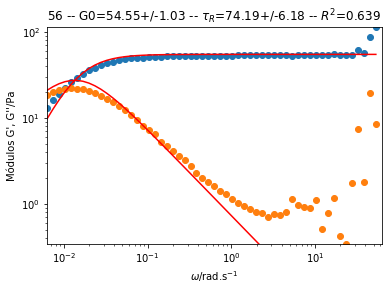

In [6]:
params = Parameters()
params.add('G0',          10., vary=True)
params.add('tr',          1. , vary=True)

aj_G0 = 10
aj_tr = 10

fits = []

for i in range(len(file['Agua1 w'])//4, len(file['Agua1 w'])): # Vai do zero até um quarto da curva até o final 
    
    dataset_x = file['Agua1 w'].iloc[0:i]
    dataset_elast = file['Agua1 G1'].iloc[0:i]
    dataset_visc = file['Agua1 G2'].iloc[0:i]

    datasets = [dataset_elast, dataset_visc]
    fit = minimize( residual, params, args=(dataset_x, datasets) )
    fits.append((fit, i))

fits.sort(key = lambda x: x[0].chisqr)

G0_fit = fits[0][0].params['G0']
tr_fit = fits[0][0].params['tr']
i = fits[0][1]

#dataset_x = file['Agua1 w'].iloc[0:i]
#dataset_elast = file['Agua1 G1'].iloc[0:i]
#dataset_visc = file['Agua1 G2'].iloc[0:i]

#modelo_elast = maxwell_elast(dataset_x, G0_fit, tr_fit)
#modelo_visc = maxwell_visc(dataset_x, G0_fit, tr_fit)

#plt.scatter(dataset_x, dataset_elast)
#plt.scatter(dataset_x, dataset_visc)
#plt.plot(dataset_x, modelo_elast, c='red')
#plt.plot(dataset_x, modelo_visc, c='red')

# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('$\omega$/rad.s$^{-1}$')
# plt.ylabel("Módulos G', G''/Pa")

# fit.chisqr == sum(fit.residuals)


fhand = open('teste.txt', 'w')
for j, val in enumerate(fits):
    plt.gca().clear()
    dest = os.path.join(os.getcwd(), 'teste', str(j).zfill(3) + '.png')
    fit = fits[j][0]
    G0_fit = fit.params['G0']
    tr_fit = fit.params['tr']
    i = fits[j][1]
    
    dataset_x = file['Agua1 w'].iloc[0:i]
    dataset_elast = file['Agua1 G1'].iloc[0:i]
    dataset_visc = file['Agua1 G2'].iloc[0:i]
    
    SStot_elast = sum((dataset_elast - np.mean(dataset_elast)) ** 2)
    SStot_visc = sum((dataset_visc - np.mean(dataset_visc)) ** 2)

    modelo_elast = maxwell_elast(dataset_x, G0_fit, tr_fit)
    modelo_visc = maxwell_visc(dataset_x, G0_fit, tr_fit)

    SSres = fit.chisqr
    SStot = SStot_elast + SStot_visc
    R2 = 1 - SSres / SStot
    
    ######################
    
    plt.scatter(dataset_x, dataset_elast)
    plt.scatter(dataset_x, dataset_visc)
    plt.plot(dataset_x, modelo_elast, c='red')
    plt.plot(dataset_x, modelo_visc, c='red')
    plt.title(str(i) + ' -- G0=' + str(round(G0_fit.value,2)) + '+/-' + str(round(G0_fit.stderr,2)) + r' -- $\tau_R$=' + 
                str(round(tr_fit.value,2)) + '+/-' + str(round(tr_fit.stderr,2)) + ' -- $R^2$=' + str(round(R2, 3)))
    
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$\omega$/rad.s$^{-1}$')
    plt.ylabel("Módulos G', G''/Pa")
    
    plt.xlim(min(file['Agua1 w']), max(file['Agua1 w']))
    plt.ylim(min(min(file['Agua1 G1']),min(file['Agua1 G2'])), max(max(file['Agua1 G1']),max(file['Agua1 G2'])))
    #plt.savefig(dest, dpi=100)
    
    #fhand.write(str(i) + ';' + str(G0_fit.value) + '+/-' + str(G0_fit.stderr) + ';' + 
    #            str(tr_fit.value) + '+/-' + str(tr_fit.stderr) + ';' + str(R2) + '\n')
fhand.close()

## Melhor R^2

Text(0.5,1,'37 -- G0=51.53+/-0.28 -- $\\tau_R$=79.43+/-1.53 -- $R^2$=0.978')

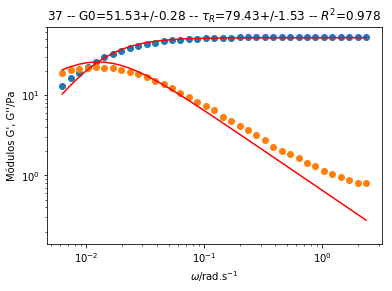

In [12]:
params = Parameters()
params.add('G0',          10., vary=True)
params.add('tr',          1. , vary=True)

aj_G0 = 10
aj_tr = 10

fits = []

for i in range(len(file['Agua1 w'])//4, len(file['Agua1 w'])): # Vai do zero até um quarto da curva até o final 
    
    dataset_x = file['Agua1 w'].iloc[0:i]
    dataset_elast = file['Agua1 G1'].iloc[0:i]
    dataset_visc = file['Agua1 G2'].iloc[0:i]

    datasets = [dataset_elast, dataset_visc]
    fit = minimize( residual, params, args=(dataset_x, datasets) )
    
    SStot_elast = sum((dataset_elast - np.mean(dataset_elast)) ** 2)
    SStot_visc = sum((dataset_visc - np.mean(dataset_visc)) ** 2)

    G0_fit = fit.params['G0']
    tr_fit = fit.params['tr']
    
    modelo_elast = maxwell_elast(dataset_x, G0_fit, tr_fit)
    modelo_visc = maxwell_visc(dataset_x, G0_fit, tr_fit)

    SSres = fit.chisqr
    SStot = SStot_elast + SStot_visc
    R2 = 1 - SSres / SStot
    fits.append((fit, i, R2))

fits.sort(key = lambda x: x[2], reverse=True)

G0_fit = fits[0][0].params['G0']
tr_fit = fits[0][0].params['tr']
i = fits[0][1]
R2 = fits[0][2]

dataset_x = file['Agua1 w'].iloc[0:i]
dataset_elast = file['Agua1 G1'].iloc[0:i]
dataset_visc = file['Agua1 G2'].iloc[0:i]

modelo_elast = maxwell_elast(dataset_x, G0_fit, tr_fit)
modelo_visc = maxwell_visc(dataset_x, G0_fit, tr_fit)

plt.scatter(dataset_x, dataset_elast)
plt.scatter(dataset_x, dataset_visc)
plt.plot(dataset_x, modelo_elast, c='red')
plt.plot(dataset_x, modelo_visc, c='red')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\omega$/rad.s$^{-1}$')
plt.ylabel("Módulos G', G''/Pa")

plt.title(str(i) + ' -- G0=' + str(round(G0_fit.value,2)) + '+/-' + str(round(G0_fit.stderr,2)) + r' -- $\tau_R$=' + 
            str(round(tr_fit.value,2)) + '+/-' + str(round(tr_fit.stderr,2)) + ' -- $R^2$=' + str(round(R2, 3)))
#plt.savefig('Água 1 R2 máximizado.png', dpi=300)

## Expandindo para todos os arquivos

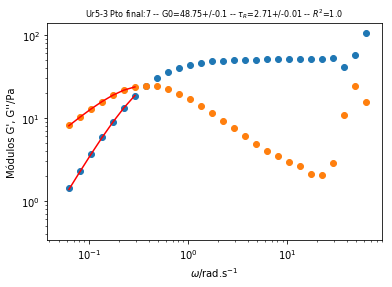

In [16]:
files = glob.glob('*.csv')
files_pd = []

for file in files:
    temp_pd = pd.read_csv(file, encoding='utf8', delimiter=';', decimal=',')
    files_pd.append(temp_pd)
    
for file in files_pd:
    wnum = 0
    G1num = 0
    G2num = 0
    
    wname = ''
    G1name = ''
    G2name = ''
    for i, col in enumerate(file.columns):
        if 'w' in col:
            wnum = i
            wname = col
        elif 'G1' in col:
            G1num = i
            G1name = col
        elif 'G2' in col:
            G2num = i
            G2name = col

    name = G1name.split(' ')[0]
    params = Parameters()
    params.add('G0',          10., vary=True)
    params.add('tr',          1. , vary=True)

    fits = []

    for i in range(len(file[wname])//4, len(file[wname])): # Vai do zero até um quarto da curva até o final 

        dataset_x = file[wname].iloc[0:i]
        dataset_elast = file[G1name].iloc[0:i]
        dataset_visc = file[G2name].iloc[0:i]

        datasets = [dataset_elast, dataset_visc]
        fit = minimize( residual, params, args=(dataset_x, datasets) )

        SStot_elast = sum((dataset_elast - np.mean(dataset_elast)) ** 2)
        SStot_visc = sum((dataset_visc - np.mean(dataset_visc)) ** 2)

        G0_fit = fit.params['G0']
        tr_fit = fit.params['tr']
        
        modelo_elast = maxwell_elast(dataset_x, G0_fit, tr_fit)
        modelo_visc = maxwell_visc(dataset_x, G0_fit, tr_fit)

        SSres = fit.chisqr
        SStot = SStot_elast + SStot_visc
        R2 = 1 - SSres / SStot
        fits.append((fit, i, R2))

    fits.sort(key = lambda x: x[2], reverse=True)

    G0_fit = fits[0][0].params['G0']
    tr_fit = fits[0][0].params['tr']
    i = fits[0][1]
    R2 = fits[0][2]

    dataset_x = file[wname].iloc[0:i]
    dataset_elast = file[G1name].iloc[0:i]
    dataset_visc = file[G2name].iloc[0:i]

    modelo_elast = maxwell_elast(dataset_x, G0_fit, tr_fit)
    modelo_visc = maxwell_visc(dataset_x, G0_fit, tr_fit)
    
    plt.gca().clear()
    plt.scatter(file[wname], file[G1name])
    plt.scatter(file[wname], file[G2name])
    plt.plot(dataset_x, modelo_elast, c='red')
    plt.plot(dataset_x, modelo_visc, c='red')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$\omega$/rad.s$^{-1}$')
    plt.ylabel("Módulos G', G''/Pa")

    plt.title(name + 
              ' Pto final:' + str(i) + 
              ' -- G0=' + str(round(G0_fit.value,2)) + '+/-' + str(round(G0_fit.stderr,2)) +
              r' -- $\tau_R$=' + str(round(tr_fit.value,2)) + '+/-' + str(round(tr_fit.stderr,2)) + 
              ' -- $R^2$=' + str(round(R2, 3)), fontsize=8
             )
    destpath = os.path.join('teste ajustes Maxwell menor r2', name + '.png')
    counter = 0
    while os.path.isfile(destpath):
        counter += 1
        destpath = os.path.join('teste ajustes Maxwell menor r2', name + '--' + str(counter) + '.png')
    plt.savefig(destpath, dpi=100)


## Escolhendo os pontos manualmente
### Plotando todos os gráficos com a numeração de cada ponto

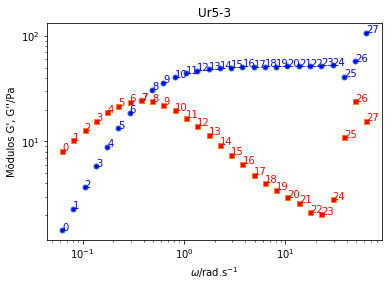

In [33]:
files = glob.glob('*.csv')
files_pd = []

for file in files:
    temp_pd = pd.read_csv(file, encoding='utf8', delimiter=';', decimal=',')
    files_pd.append(temp_pd)
    
for file in files_pd:
    wnum = 0
    G1num = 0
    G2num = 0
    
    wname = ''
    G1name = ''
    G2name = ''
    for i, col in enumerate(file.columns):
        if 'w' in col:
            wnum = i
            wname = col
        elif 'G1' in col:
            G1num = i
            G1name = col
        elif 'G2' in col:
            G2num = i
            G2name = col

    name = G1name.split(' ')[0]

    plt.gca().clear()
    plt.plot(file[wname], file[G1name], linewidth=0, marker='o', markerfacecolor='blue', markersize=5)
    plt.plot(file[wname], file[G2name], linewidth=0, marker='s', markerfacecolor='red', markersize=5)
    
    for i, val in enumerate(file[G1name]):
        plt.text(file[wname].iloc[i], file[G1name].iloc[i], str(i), color='blue')
        plt.text(file[wname].iloc[i], file[G2name].iloc[i], str(i), color='red')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$\omega$/rad.s$^{-1}$')
    plt.ylabel("Módulos G', G''/Pa")

    plt.title(name)
    destpath = os.path.join('plots numerados', name + '.png')
    counter = 0
    while os.path.isfile(destpath):
        counter += 1
        destpath = os.path.join('plots numerados', name + '--' + str(counter) + '.png')
    plt.savefig(destpath, dpi=100)

### Reutilizando o código, mas pedindo para escolher o ponto final

13BD15-2 -- Qual é o ponto final?  20
13BD15-3 -- Qual é o ponto final?  23
13BD25-2 -- Qual é o ponto final?  21
Agua1 -- Qual é o ponto final?  36
Agua2 -- Qual é o ponto final?  27
Agua3 -- Qual é o ponto final?  23
DMSO15-1 -- Qual é o ponto final?  24
DMSO15-2 -- Qual é o ponto final?  26
DMSO15-3 -- Qual é o ponto final?  26
DMSO25-1 -- Qual é o ponto final?  25
DMSO25-2 -- Qual é o ponto final?  17
DMSO25-3 -- Qual é o ponto final?  20
Glic30-1 -- Qual é o ponto final?  21
Glic30-2 -- Qual é o ponto final?  26
Glic30-3 -- Qual é o ponto final?  25
Glic60-1 -- Qual é o ponto final?  18
Glic60-2 -- Qual é o ponto final?  26
Glic60-3 -- Qual é o ponto final?  27
Glic60-3 -- Qual é o ponto final?  12
Sac50-1 -- Qual é o ponto final?  36
Sac50-2 -- Qual é o ponto final?  27
Sac50-3 -- Qual é o ponto final?  27
Ur15-1 -- Qual é o ponto final?  24
Ur15-1 -- Qual é o ponto final?  25
Ur15-1 -- Qual é o ponto final?  21
Ur15-2 -- Qual é o ponto final?  23
Ur15-2 -- Qual é o ponto final? 

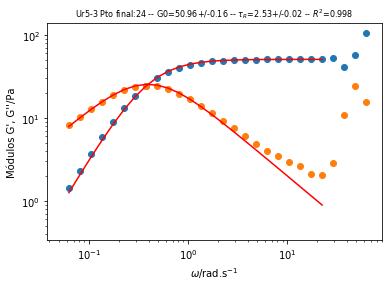

In [38]:
files = glob.glob('*.csv')
files_pd = []

for file in files:
    temp_pd = pd.read_csv(file, encoding='utf8', delimiter=';', decimal=',')
    files_pd.append(temp_pd)
    
for file in files_pd:
    wnum = 0
    G1num = 0
    G2num = 0
    
    wname = ''
    G1name = ''
    G2name = ''
    for i, col in enumerate(file.columns):
        if 'w' in col:
            wnum = i
            wname = col
        elif 'G1' in col:
            G1num = i
            G1name = col
        elif 'G2' in col:
            G2num = i
            G2name = col

    name = G1name.split(' ')[0]
    params = Parameters()
    params.add('G0',          10., vary=True, min=0)
    params.add('tr',          1. , vary=True, min=0)
    
    final = int(input(name + ' -- Qual é o ponto final?  '))
    
    #for i in range(len(file[wname])//4, len(file[wname])): # Vai do zero até um quarto da curva até o final 

    dataset_x = file[wname].iloc[0:final]
    dataset_elast = file[G1name].iloc[0:final]
    dataset_visc = file[G2name].iloc[0:final]

    datasets = [dataset_elast, dataset_visc]
    fit = minimize( residual, params, args=(dataset_x, datasets) )

    SStot_elast = sum((dataset_elast - np.mean(dataset_elast)) ** 2)
    SStot_visc = sum((dataset_visc - np.mean(dataset_visc)) ** 2)

    G0_fit = fit.params['G0']
    tr_fit = fit.params['tr']

    modelo_elast = maxwell_elast(dataset_x, G0_fit, tr_fit)
    modelo_visc = maxwell_visc(dataset_x, G0_fit, tr_fit)

    SSres = fit.chisqr
    SStot = SStot_elast + SStot_visc
    R2 = 1 - SSres / SStot


    dataset_x = file[wname].iloc[0:final]
    dataset_elast = file[G1name].iloc[0:final]
    dataset_visc = file[G2name].iloc[0:final]

    modelo_elast = maxwell_elast(dataset_x, G0_fit, tr_fit)
    modelo_visc = maxwell_visc(dataset_x, G0_fit, tr_fit)
    
    plt.gca().clear()
    plt.scatter(file[wname], file[G1name])
    plt.scatter(file[wname], file[G2name])
    plt.plot(dataset_x, modelo_elast, c='red')
    plt.plot(dataset_x, modelo_visc, c='red')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$\omega$/rad.s$^{-1}$')
    plt.ylabel("Módulos G', G''/Pa")

    plt.title(name + 
              ' Pto final:' + str(final) + 
              ' -- G0=' + str(round(G0_fit.value,2)) + '+/-' + str(round(G0_fit.stderr,2)) +
              r' -- $\tau_R$=' + str(round(tr_fit.value,2)) + '+/-' + str(round(tr_fit.stderr,2)) + 
              ' -- $R^2$=' + str(round(R2, 3)), fontsize=8
             )
    with open(os.path.join('teste ajustes Maxwell manual', 'ajustes_pontos.txt'), 'a') as fhand:
        fhand.write(name + ';' + 
                   str(final) + ';' + 
                   str(G0_fit.value) + ';' +  str(G0_fit.stderr) + ';' + 
                   str(tr_fit.value) + ';' + str(tr_fit.stderr) + ';' +
                   str(R2) + '\n')
    destpath = os.path.join('teste ajustes Maxwell manual', name + '.png')
    counter = 0
    while os.path.isfile(destpath):
        counter += 1
        destpath = os.path.join('teste ajustes Maxwell manual', name + '--' + str(counter) + '.png')
    plt.savefig(destpath, dpi=100)


## Replotando os gráficos utilizando os mesmos pontos escolhidos manualmente
### Refazendo os ajustes aplicando log antes e verificando se há diferença

In [4]:
pontos_pd = pd.read_csv('ajustes_pontos_manual_Maxwell.txt', encoding='utf8', sep=';')
pontos = pontos_pd['pto_final']

files = glob.glob('*.csv')
files_pd = []

for file in files:
    temp_pd = pd.read_csv(file, encoding='utf8', delimiter=';', decimal=',')
    files_pd.append(temp_pd)

    
for i, file in enumerate(files_pd):
    wnum = 0
    G1num = 0
    G2num = 0
    
    wname = ''
    G1name = ''
    G2name = ''
    for j, col in enumerate(file.columns):
        if 'w' in col:
            wnum = j
            wname = col
        elif 'G1' in col:
            G1num = j
            G1name = col
        elif 'G2' in col:
            G2num = j
            G2name = col

    name = G1name.split(' ')[0]
    params = Parameters()
    params.add('G0',          10., vary=True, min=0)
    params.add('tr',          1. , vary=True, min=0)
    
    final = pontos[i]
    dataset_x = file[wname][:final]
    dataset_elast = file[G1name][:final]
    dataset_visc = file[G2name][:final]
    datasets = [dataset_elast, dataset_visc]
   
    fit = minimize( residual, params, args=(dataset_x, datasets) )

    SStot_elast = sum((dataset_elast - np.mean(dataset_elast)) ** 2)
    SStot_visc = sum((dataset_visc - np.mean(dataset_visc)) ** 2)

    G0_fit = fit.params['G0']
    tr_fit = fit.params['tr']

    modelo_elast = maxwell_elast(dataset_x, G0_fit, tr_fit)
    modelo_visc = maxwell_visc(dataset_x, G0_fit, tr_fit)

    SSres = fit.chisqr
    SStot = SStot_elast + SStot_visc
    R2 = 1 - SSres / SStot

    plt.gca().clear()
    plt.scatter(file[wname], file[G1name])
    plt.scatter(file[wname], file[G2name])
    plt.plot(dataset_x, modelo_elast, c='red')
    plt.plot(dataset_x, modelo_visc, c='red')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$\omega$/rad.s$^{-1}$')
    plt.ylabel("Módulos G', G''/Pa")

    plt.title(name + 
              ' Pto final:' + str(final) + 
              ' -- G0=' + str(round(G0_fit.value,2)) + '+/-' + str(round(G0_fit.stderr,2)) +
              r' -- $\tau_R$=' + str(round(tr_fit.value,2)) + '+/-' + str(round(tr_fit.stderr,2)) + 
              ' -- $R^2$=' + str(round(R2, 3)), fontsize=8
             )

    with open(os.path.join('teste ajustes Maxwell manual', 'ajustes_pontos.txt'), 'a') as fhand:
        fhand.write(name + ';' + 
                   str(final) + ';' + 
                   str(G0_fit.value) + ';' +  str(G0_fit.stderr) + ';' + 
                   str(tr_fit.value) + ';' + str(tr_fit.stderr) + ';' +
                   str(R2) + '\n')
    
    destpath = os.path.join('teste ajustes Maxwell manual', name + '.png')
    counter = 0
    while os.path.isfile(destpath):
        counter += 1
        destpath = os.path.join('teste ajustes Maxwell manual', name + '--' + str(counter) + '.png')
    plt.savefig(destpath, dpi=100)

### Refazendo os ajustes aplicando log antes e verificando se há diferença

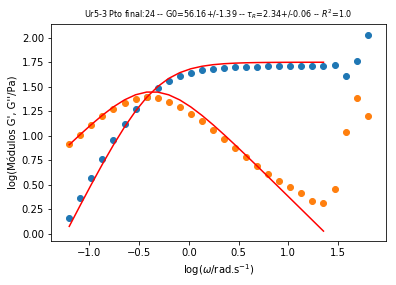

In [35]:
pontos_pd = pd.read_csv('ajustes_pontos_manual_Maxwell.txt', encoding='utf8', sep=';')
pontos = pontos_pd['pto_final']

files = glob.glob('*.csv')
files_pd = []

for file in files:
    temp_pd = pd.read_csv(file, encoding='utf8', delimiter=';', decimal=',')
    files_pd.append(temp_pd)

    
for i, file in enumerate(files_pd):
    wnum = 0
    G1num = 0
    G2num = 0
    
    wname = ''
    G1name = ''
    G2name = ''
    for j, col in enumerate(file.columns):
        if 'w' in col:
            wnum = j
            wname = col
        elif 'G1' in col:
            G1num = j
            G1name = col
        elif 'G2' in col:
            G2num = j
            G2name = col

    name = G1name.split(' ')[0]
    params = Parameters()
    params.add('G0',          10., vary=True, min=0)
    params.add('tr',          1. , vary=True, min=0)
    
    final = pontos[i]
    dataset_x = file[wname][:final]
    dataset_elast = file[G1name][:final]
    dataset_visc = file[G2name][:final]
    datasets = [dataset_elast, dataset_visc]
   
    fit = minimize( residual_log, params, args=(dataset_x, datasets) )

    SStot_elast = sum((dataset_elast - np.mean(dataset_elast)) ** 2)
    SStot_visc = sum((dataset_visc - np.mean(dataset_visc)) ** 2)

    G0_fit = fit.params['G0']
    tr_fit = fit.params['tr']

    modelo_elast = np.log10(maxwell_elast(dataset_x, G0_fit, tr_fit))
    modelo_visc = np.log10(maxwell_visc(dataset_x, G0_fit, tr_fit))

    SSres = fit.chisqr
    SStot = SStot_elast + SStot_visc
    R2 = 1 - SSres / SStot

    plt.gca().clear()
    plt.scatter(np.log10(file[wname]), np.log10(file[G1name]))
    plt.scatter(np.log10(file[wname]), np.log10(file[G2name]))
    plt.plot(np.log10(dataset_x), modelo_elast, c='red')
    plt.plot(np.log10(dataset_x), modelo_visc, c='red')

    #plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel('log($\omega$/rad.s$^{-1}$)')
    plt.ylabel("log(Módulos G', G''/Pa)")

    plt.title(name + 
              ' Pto final:' + str(final) + 
              ' -- G0=' + str(round(G0_fit.value,2)) + '+/-' + str(round(G0_fit.stderr,2)) +
              r' -- $\tau_R$=' + str(round(tr_fit.value,2)) + '+/-' + str(round(tr_fit.stderr,2)) + 
              ' -- $R^2$=' + str(round(R2, 3)), fontsize=8
             )

    with open(os.path.join('teste ajustes Maxwell manual log', 'ajustes_pontos.txt'), 'a') as fhand:
        fhand.write(name + ';' + 
                   str(final) + ';' + 
                   str(G0_fit.value) + ';' +  str(G0_fit.stderr) + ';' + 
                   str(tr_fit.value) + ';' + str(tr_fit.stderr) + ';' +
                   str(R2) + '\n')
    
    destpath = os.path.join('teste ajustes Maxwell manual log', name + '.png')
    counter = 0
    while os.path.isfile(destpath):
        counter += 1
        destpath = os.path.join('teste ajustes Maxwell manual log', name + '--' + str(counter) + '.png')
    plt.savefig(destpath, dpi=100)

## Comparando os ajustes na escala normal e na escala log

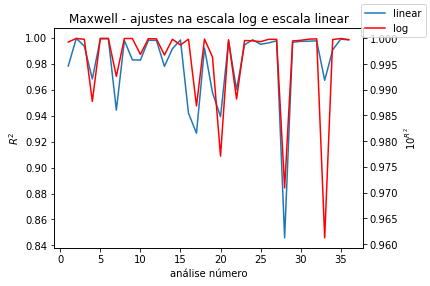

In [188]:
normal = pd.read_csv('ajustes_pontos_manual_Maxwell_sem_13BD.txt', sep=';')
log = pd.read_csv('ajustes_pontos_manual_Maxwell_log_sem_13BD.txt', sep=';')

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
#plt.plot(normal['r2'], log['r2'], linewidth=0, marker='o', markersize=5, markeredgecolor='blue')
ax1.plot(range(1, len(normal['r2']) + 1), normal['r2'], label='normal')

pows = np.array([10] * len(log['r2']))
r2novo = np.power(log['r2'], pows)

ax2.plot(range(1, len(log['r2']) + 1), r2novo, label='log', c='r')
#plt.plot(np.linspace(0.84, 1), np.linspace(0.84, 1))
ax1.set_xlabel('análise número')
ax1.set_ylabel('$R^2$')
ax2.set_ylabel('$10^{R^2}$')

plt.title('Maxwell - ajustes na escala log e escala linear')
fig.legend((ax1.get_lines()[0], ax2.get_lines()[0]), ('linear', 'log'))
fig.tight_layout()
plt.savefig('Comparação_R2_Maxwell_linear_e_10^log.png', dpi=300)

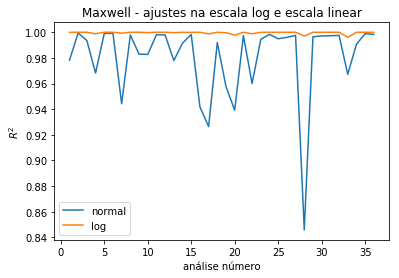

In [159]:
normal = pd.read_csv('ajustes_pontos_manual_Maxwell_sem_13BD.txt', sep=';')
log = pd.read_csv('ajustes_pontos_manual_Maxwell_log_sem_13BD.txt', sep=';')

#plt.plot(normal['r2'], log['r2'], linewidth=0, marker='o', markersize=5, markeredgecolor='blue')
plt.plot(range(1, len(normal['r2']) + 1), normal['r2'], label='normal')
plt.plot(range(1, len(log['r2']) + 1), log['r2'], label='log')
#plt.plot(np.linspace(0.84, 1), np.linspace(0.84, 1))
plt.xlabel('análise número')
plt.ylabel('$R^2$')
plt.title('Maxwell - ajustes na escala log e escala linear')
plt.legend()
plt.savefig('Comparação R2 Maxwell linear e log.png', dpi=300)

## Utilizando o modelo de OldroydB

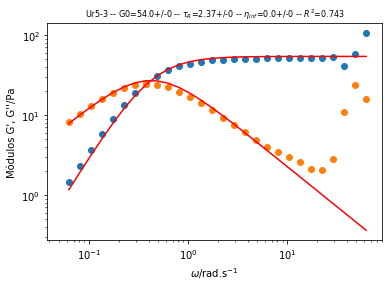

In [28]:
files = glob.glob('*.csv')
files_pd = []

for file in files:
    temp_pd = pd.read_csv(file, encoding='utf8', delimiter=';', decimal=',')
    files_pd.append(temp_pd)
    
for file in files_pd:
    wnum = 0
    G1num = 0
    G2num = 0
    
    wname = ''
    G1name = ''
    G2name = ''
    for i, col in enumerate(file.columns):
        if 'w' in col:
            wnum = i
            wname = col
        elif 'G1' in col:
            G1num = i
            G1name = col
        elif 'G2' in col:
            G2num = i
            G2name = col

    name = G1name.split(' ')[0]
    params = Parameters()
    params.add('G0',          10., vary=True, min=0)
    params.add('tr',          1. , vary=True, min=0)
    params.add('eta_inf',          0 , vary=True, min=0)

#     fits = []

    #for i in range(len(file[wname]), len(file[wname])): 

    dataset_x = file[wname]
    dataset_elast = file[G1name]
    dataset_visc = file[G2name]
    
    #dataset_elast = savgol_filter(dataset_elast, window_length=7, polyorder=3)
    #dataset_visc = savgol_filter(dataset_visc, window_length=7, polyorder=3)

    datasets = [dataset_elast, dataset_visc]
    
    fit = minimize( residual_oldroyd, params, args=(dataset_x, datasets) )

    G0_fit = fit.params['G0']
    tr_fit = fit.params['tr']
    eta_inf_fit = fit.params['eta_inf']
    
    modelo_elast = oldroydB_elast(dataset_x, G0_fit, tr_fit)
    modelo_visc = oldroydB_visc(dataset_x, G0_fit, tr_fit, eta_inf_fit)

    SStot_elast = sum((dataset_elast - np.mean(dataset_elast)) ** 2)
    SStot_visc = sum((dataset_visc - np.mean(dataset_visc)) ** 2)
    SSres = fit.chisqr
    SStot = SStot_elast + SStot_visc
    R2 = 1 - SSres / SStot
#     fits.append((fit, R2))

#     fits.sort(key = lambda x: x[1], reverse=True)

#     G0_fit = fits[0][0].params['G0']
#     tr_fit = fits[0][0].params['tr']
#     eta_inf_fit = fits[0][0].params['eta_inf']
#     R2 = fits[0][2]

#     dataset_x = file[wname].iloc[0:i]
#     dataset_elast = file[G1name].iloc[0:i]
#     dataset_visc = file[G2name].iloc[0:i]

#     modelo_elast = oldroydB_elast(dataset_x, G0_fit, tr_fit)
#     modelo_visc = oldroydB_visc(dataset_x, G0_fit, tr_fit, eta_inf_fit)
    
    plt.gca().clear()
    plt.scatter(file[wname], file[G1name])
    plt.scatter(file[wname], file[G2name])
    plt.plot(dataset_x, modelo_elast, c='red')
    plt.plot(dataset_x, modelo_visc, c='red')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$\omega$/rad.s$^{-1}$')
    plt.ylabel("Módulos G', G''/Pa")

    plt.title(
              name + 
              ' -- G0=' + str(round(G0_fit.value,2)) + '+/-' + str(round(G0_fit.stderr,2)) +
              r' -- $\tau_R$=' + str(round(tr_fit.value,2)) + '+/-' + str(round(tr_fit.stderr,2)) + 
              r' -- $\eta_{inf}$=' + str(round(eta_inf_fit.value, 2)) + '+/-' + str(round(eta_inf_fit.stderr, 2)) + 
              ' -- $R^2$=' + str(round(R2, 3)), fontsize=8
             )
    destpath = os.path.join('teste ajustes Oldroyd menor r2 savgol', name + '.png')
    counter = 0
    while os.path.isfile(destpath):
        counter += 1
        destpath = os.path.join('teste ajustes Oldroyd menor r2 savgol', name + '--' + str(counter) + '.png')
    plt.savefig(destpath, dpi=100)


## Oldroyd: Escolhendo os pontos manualmente
### Ajuste de Oldroyd utilizando os mesmos pontos que o ajuste manual de Maxwell

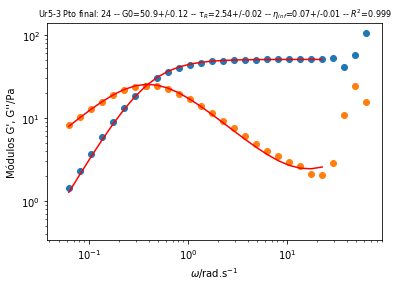

In [16]:
pontos_pd = pd.read_csv('ajustes_pontos_manual_Maxwell.txt', encoding='utf8', sep=';')
pontos = pontos_pd['pto_final']

files = glob.glob('*.csv')
files_pd = []

for file in files:
    temp_pd = pd.read_csv(file, encoding='utf8', delimiter=';', decimal=',')
    files_pd.append(temp_pd)
      
    
for i, file in enumerate(files_pd):
    wnum = 0
    G1num = 0
    G2num = 0
    
    wname = ''
    G1name = ''
    G2name = ''
    for j, col in enumerate(file.columns):
        if 'w' in col:
            wnum = j
            wname = col
        elif 'G1' in col:
            G1num = j
            G1name = col
        elif 'G2' in col:
            G2num = j
            G2name = col
    
    final = pontos[i]
    dataset_x = file[wname][:final]
    dataset_elast = file[G1name][:final]
    dataset_visc = file[G2name][:final]
    datasets = [dataset_elast, dataset_visc]
    
    name = G1name.split(' ')[0]
    params = Parameters()
    params.add('G0',          10., vary=True, min=0)
    params.add('tr',          1. , vary=True, min=0)
    params.add('eta_inf',          1 , vary=True, min=0)

    fit = minimize( residual_oldroyd, params, args=(dataset_x, datasets) )

    G0_fit = fit.params['G0']
    tr_fit = fit.params['tr']
    eta_inf_fit = fit.params['eta_inf']
    
    modelo_elast = oldroydB_elast(dataset_x, G0_fit, tr_fit)
    modelo_visc = oldroydB_visc(dataset_x, G0_fit, tr_fit, eta_inf_fit)

    SStot_elast = sum((dataset_elast - np.mean(dataset_elast)) ** 2)
    SStot_visc = sum((dataset_visc - np.mean(dataset_visc)) ** 2)
    SSres = fit.chisqr
    SStot = SStot_elast + SStot_visc
    R2 = 1 - SSres / SStot
    
    plt.gca().clear()
    plt.scatter(file[wname], file[G1name])
    plt.scatter(file[wname], file[G2name])
    plt.plot(dataset_x, modelo_elast, c='red')
    plt.plot(dataset_x, modelo_visc, c='red')

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('$\omega$/rad.s$^{-1}$')
    plt.ylabel("Módulos G', G''/Pa")

    plt.title(
              name + ' Pto final: ' + str(final) +
              ' -- G0=' + str(round(G0_fit.value,2)) + '+/-' + str(round(G0_fit.stderr,2)) +
              r' -- $\tau_R$=' + str(round(tr_fit.value,2)) + '+/-' + str(round(tr_fit.stderr,2)) + 
              r' -- $\eta_{inf}$=' + str(round(eta_inf_fit.value, 2)) + '+/-' + str(round(eta_inf_fit.stderr, 2)) + 
              ' -- $R^2$=' + str(round(R2, 3)), fontsize=8
             )
    with open(os.path.join('teste ajustes Oldroyd manual', 'ajustes_pontos.txt'), 'a') as fhand:
        fhand.write(name + ';' + 
                   str(final) + ';' + 
                   str(G0_fit.value) + ';' +  str(G0_fit.stderr) + ';' + 
                   str(tr_fit.value) + ';' + str(tr_fit.stderr) + ';' +
                   str(eta_inf_fit.value) + ';' + str(eta_inf_fit.stderr) + ';' + 
                   str(R2) + '\n')
    destpath = os.path.join('teste ajustes Oldroyd manual', name + '.png')
    counter = 0
    while os.path.isfile(destpath):
        counter += 1
        destpath = os.path.join('teste ajustes Oldroyd manual', name + '--' + str(counter) + '.png')
    plt.savefig(destpath, dpi=100)


## Realizando os ajustes de Oldroyd com a escala log

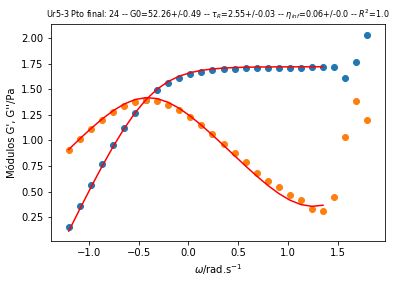

In [82]:
pontos_pd = pd.read_csv('ajustes_pontos_manual_Maxwell.txt', encoding='utf8', sep=';')
pontos = pontos_pd['pto_final']

files = glob.glob('*.csv')
files_pd = []

for file in files:
    temp_pd = pd.read_csv(file, encoding='utf8', delimiter=';', decimal=',')
    files_pd.append(temp_pd)

for i, file in enumerate(files_pd):
    wnum = 0
    G1num = 0
    G2num = 0
    
    wname = ''
    G1name = ''
    G2name = ''
    for j, col in enumerate(file.columns):
        if 'w' in col:
            wnum = j
            wname = col
        elif 'G1' in col:
            G1num = j
            G1name = col
        elif 'G2' in col:
            G2num = j
            G2name = col
    
    final = pontos[i]
    dataset_x = file[wname][:final]
    dataset_elast = file[G1name][:final]
    dataset_visc = file[G2name][:final]
    datasets = [dataset_elast, dataset_visc]
    
    name = G1name.split(' ')[0]
    params = Parameters()
    params.add('G0',          10., vary=True, min=0)
    params.add('tr',          1. , vary=True, min=0)
    params.add('eta_inf',          1 , vary=True, min=0)

    fit = minimize( residual_oldroyd_log, params, args=(dataset_x, datasets) )

    G0_fit = fit.params['G0']
    tr_fit = fit.params['tr']
    eta_inf_fit = fit.params['eta_inf']
    
    modelo_elast = np.log10(oldroydB_elast(dataset_x, G0_fit, tr_fit))
    modelo_visc = np.log10(oldroydB_visc(dataset_x, G0_fit, tr_fit, eta_inf_fit))

    SStot_elast = sum((dataset_elast - np.mean(dataset_elast)) ** 2)
    SStot_visc = sum((dataset_visc - np.mean(dataset_visc)) ** 2)
    SSres = fit.chisqr
    SStot = SStot_elast + SStot_visc
    R2 = 1 - SSres / SStot
    
    plt.gca().clear()
    plt.scatter(np.log10(file[wname]), np.log10(file[G1name]))
    plt.scatter(np.log10(file[wname]), np.log10(file[G2name]))
    plt.plot(np.log10(dataset_x), modelo_elast, c='red')
    plt.plot(np.log10(dataset_x), modelo_visc, c='red')

#     plt.xscale('log')
#     plt.yscale('log')
    plt.xlabel('$\omega$/rad.s$^{-1}$')
    plt.ylabel("Módulos G', G''/Pa")
    
    plt.title(
              name + ' Pto final: ' + str(final) +
              ' -- G0=' + str(round(G0_fit.value,2)) + '+/-' + str(round(G0_fit.stderr,2)) +
              r' -- $\tau_R$=' + str(round(tr_fit.value,2)) + '+/-' + str(round(tr_fit.stderr,2)) + 
              r' -- $\eta_{inf}$=' + str(round(eta_inf_fit.value, 2)) + '+/-' + str(round(eta_inf_fit.stderr, 2)) + 
              ' -- $R^2$=' + str(round(R2, 3)), fontsize=8
             )
    with open(os.path.join('teste ajustes Oldroyd manual log', 'ajustes_pontos.txt'), 'a') as fhand:
        fhand.write(name + ';' + 
                   str(final) + ';' + 
                   str(G0_fit.value) + ';' +  str(G0_fit.stderr) + ';' + 
                   str(tr_fit.value) + ';' + str(tr_fit.stderr) + ';' +
                   str(eta_inf_fit.value) + ';' + str(eta_inf_fit.stderr) + ';' + 
                   str(R2) + '\n')
    destpath = os.path.join('teste ajustes Oldroyd manual log', name + '.png')
    counter = 0
    while os.path.isfile(destpath):
        counter += 1
        destpath = os.path.join('teste ajustes Oldroyd manual log', name + '--' + str(counter) + '.png')
    plt.savefig(destpath, dpi=100)


### Comparação dos $R^2$ de OldroydB

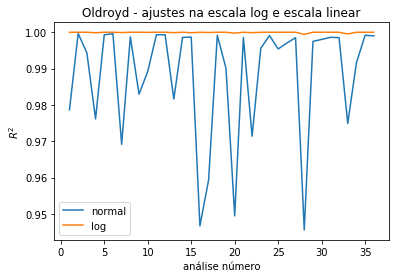

In [92]:
normal = pd.read_csv('ajustes_pontos_manual_Oldroyd_sem_13BD.txt', sep=';')
log = pd.read_csv('ajustes_pontos_manual_Oldroyd_log_sem_13BD.txt', sep=';')

#plt.plot(normal['r2'], log['r2'], linewidth=0, marker='o', markersize=5, markeredgecolor='blue')
plt.plot(range(1, len(normal['r2']) + 1), normal['r2'], label='normal')
plt.plot(range(1, len(log['r2']) + 1), log['r2'], label='log')
#plt.plot(np.linspace(0.84, 1), np.linspace(0.84, 1))
plt.xlabel('análise número')
plt.ylabel('$R^2$')
plt.title('Oldroyd - ajustes na escala log e escala linear')
plt.legend()
plt.savefig('Comparação R2 Oldroyd linear e log.png', dpi=300)

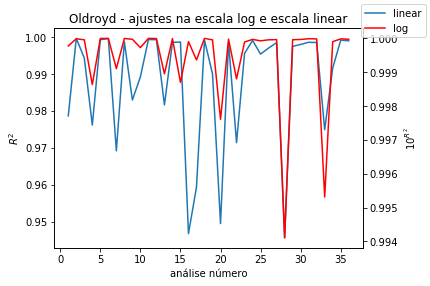

In [190]:
normal = pd.read_csv('ajustes_pontos_manual_Oldroyd_sem_13BD.txt', sep=';')
log = pd.read_csv('ajustes_pontos_manual_Oldroyd_log_sem_13BD.txt', sep=';')

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
#plt.plot(normal['r2'], log['r2'], linewidth=0, marker='o', markersize=5, markeredgecolor='blue')
ax1.plot(range(1, len(normal['r2']) + 1), normal['r2'], label='normal')

pows = np.array([10] * len(log['r2']))
r2novo = np.power(log['r2'], pows)

ax2.plot(range(1, len(log['r2']) + 1), r2novo, label='log', c='r')
#plt.plot(np.linspace(0.84, 1), np.linspace(0.84, 1))
ax1.set_xlabel('análise número')
ax1.set_ylabel('$R^2$')
ax2.set_ylabel('$10^{R^2}$')

plt.title('Oldroyd - ajustes na escala log e escala linear')
fig.legend((ax1.get_lines()[0], ax2.get_lines()[0]), ('linear', 'log'))
fig.tight_layout()
plt.savefig('Comparação_R2_Oldroyd_linear_e_10^log.png', dpi=300)

## Comparando Oldroyd e Maxwell -- $R^2$

In [9]:
ptos_maxwell = pd.read_csv('ajustes_pontos_manual_Maxwell_sem_13BD.txt', sep=';', encoding='utf8')
ptos_oldroyd = pd.read_csv('ajustes_pontos_manual_Oldroyd_sem_13BD.txt', sep=';', encoding='utf8')

,nome,pto_final,G0,G0_err,tau_r,tau_r_err,eta_inf,eta_inf_err,r2
12,Glic60-1,18,18.272958,1.059078,0.036398,0.002313,5.451660e-02,0.017387,0.981618
8,DMSO25-3,20,54.823637,1.473410,0.041528,0.001757,1.435252e-11,0.000735,0.982939
15,Glic60-3,12,45.413595,1.570247,0.042990,0.002747,3.029529e-02,0.021234,0.946709
14,Glic60-3,27,43.293232,0.451925,0.046415,0.000619,3.847165e-02,0.008903,0.998670
5,DMSO15-3,26,49.009181,0.144096,0.159272,0.000928,4.187323e-02,0.005985,0.999586


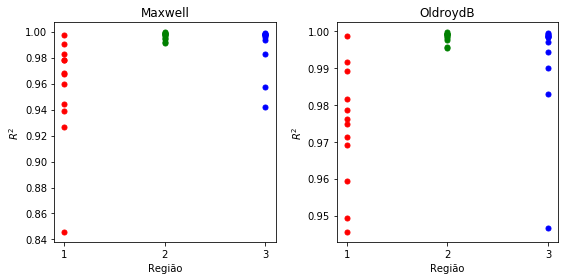

In [4]:
ptos_maxwell = pd.read_csv('ajustes_pontos_manual_Maxwell_sem_13BD.txt', sep=';', encoding='utf8')
ptos_oldroyd = pd.read_csv('ajustes_pontos_manual_Oldroyd_sem_13BD.txt', sep=';', encoding='utf8')

maxwell_int_1 = ptos_maxwell[ptos_maxwell['nome'].str.endswith('1')]
maxwell_int_2 = ptos_maxwell[ptos_maxwell['nome'].str.endswith('2')]
maxwell_int_3 = ptos_maxwell[ptos_maxwell['nome'].str.endswith('3')]

lst1_m = ['1'] * len(maxwell_int_1)
lst2_m = ['2'] * len(maxwell_int_2)
lst3_m = ['3'] * len(maxwell_int_3)

oldroyd_int_1 = ptos_oldroyd[ptos_oldroyd['nome'].str.endswith('1')]
oldroyd_int_2 = ptos_oldroyd[ptos_oldroyd['nome'].str.endswith('2')]
oldroyd_int_3 = ptos_oldroyd[ptos_oldroyd['nome'].str.endswith('3')]

lst1_o = ['1'] * len(oldroyd_int_1)
lst2_o = ['2'] * len(oldroyd_int_2)
lst3_o = ['3'] * len(oldroyd_int_3)

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax1.plot(lst1_m, maxwell_int_1['r2'], linewidth=0, markersize=5, markerfacecolor='r', markeredgecolor='r', marker='o')
ax1.plot(lst2_m, maxwell_int_2['r2'], linewidth=0, markersize=5, markerfacecolor='g', markeredgecolor='g', marker='o')
ax1.plot(lst3_m, maxwell_int_3['r2'], linewidth=0, markersize=5, markerfacecolor='b', markeredgecolor='b', marker='o')
ax1.set_ylabel('$R^2$')
ax1.set_xlabel('Região')
ax1.set_title('Maxwell')

ax2.plot(lst1_o, oldroyd_int_1['r2'], linewidth=0, markersize=5, markerfacecolor='r', markeredgecolor='r', marker='o')
ax2.plot(lst2_o, oldroyd_int_2['r2'], linewidth=0, markersize=5, markerfacecolor='g', markeredgecolor='g', marker='o')
ax2.plot(lst3_o, oldroyd_int_3['r2'], linewidth=0, markersize=5, markerfacecolor='b', markeredgecolor='b', marker='o')
ax2.set_ylabel('$R^2$')
ax2.set_xlabel('Região')
ax2.set_title('OldroydB')

fig.tight_layout()
fig.savefig('R2 das regiões 1, 2 e 3', dpi=150)

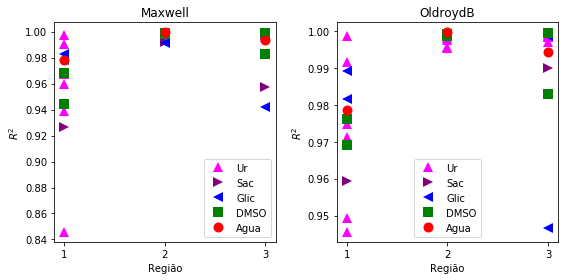

In [5]:
ptos_maxwell = pd.read_csv('ajustes_pontos_manual_Maxwell_sem_13BD.txt', sep=';', encoding='utf8')
ptos_oldroyd = pd.read_csv('ajustes_pontos_manual_Oldroyd_sem_13BD.txt', sep=';', encoding='utf8')

ptos_maxwell['reg'] = ptos_maxwell['nome'].str.get(-1)
ptos_oldroyd['reg'] = ptos_oldroyd['nome'].str.get(-1)

nomes = ['Agua', 'DMSO', 'Glic', 'Sac', 'Ur']
cores = ['red', 'green', 'blue', 'purple', 'magenta']
simbolos = ['o', 's', '<', '>', '^']

nomes.reverse()

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
MARKERSIZE=10

for nome in nomes:
    maxwell_int_1 = ptos_maxwell[ptos_maxwell['nome'].str.endswith('1') & ptos_maxwell['nome'].str.contains(nome)]
    maxwell_int_2 = ptos_maxwell[ptos_maxwell['nome'].str.endswith('2') & ptos_maxwell['nome'].str.contains(nome)]
    maxwell_int_3 = ptos_maxwell[ptos_maxwell['nome'].str.endswith('3') & ptos_maxwell['nome'].str.contains(nome)]

    lst1 = ['1'] * len(maxwell_int_1)
    lst2 = ['2'] * len(maxwell_int_2)
    lst3 = ['3'] * len(maxwell_int_3)

    oldroyd_int_1 = ptos_oldroyd[ptos_oldroyd['nome'].str.endswith('1') & ptos_oldroyd['nome'].str.contains(nome)]
    oldroyd_int_2 = ptos_oldroyd[ptos_oldroyd['nome'].str.endswith('2') & ptos_oldroyd['nome'].str.contains(nome)]
    oldroyd_int_3 = ptos_oldroyd[ptos_oldroyd['nome'].str.endswith('3') & ptos_oldroyd['nome'].str.contains(nome)]

    lst1 = ['1'] * len(oldroyd_int_1)
    lst2 = ['2'] * len(oldroyd_int_2)
    lst3 = ['3'] * len(oldroyd_int_3)

    cor = cores.pop()
    simbolo = simbolos.pop()
    
    ax1.plot(lst1, maxwell_int_1['r2'], linewidth=0, markersize=MARKERSIZE, 
         markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
    ax1.plot(lst2, maxwell_int_2['r2'], linewidth=0, markersize=MARKERSIZE, 
         markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
    ax1.plot(lst3, maxwell_int_3['r2'], linewidth=0, markersize=MARKERSIZE, 
         markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)  

    ax1.set_ylabel('$R^2$')
    ax1.set_xlabel('Região')
    ax1.set_title('Maxwell')
    
    ax2.plot(lst1, oldroyd_int_1['r2'], linewidth=0, markersize=MARKERSIZE, 
             markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
    ax2.plot(lst2, oldroyd_int_2['r2'], linewidth=0, markersize=MARKERSIZE,
             markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
    ax2.plot(lst3, oldroyd_int_3['r2'], linewidth=0, markersize=MARKERSIZE,
             markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
    ax2.set_ylabel('$R^2$')
    ax2.set_xlabel('Região')
    ax2.set_title('OldroydB')

lines_ax1 = list(ax1.get_lines())
lines_ax2 = list(ax2.get_lines())


ax1.legend(lines_ax1[::3], nomes)
ax2.legend(lines_ax2[::3], nomes)
fig.tight_layout()
fig.savefig('R2 das regiões 1, 2 e 3 com nomes', dpi=300)

## Escala logarítmica

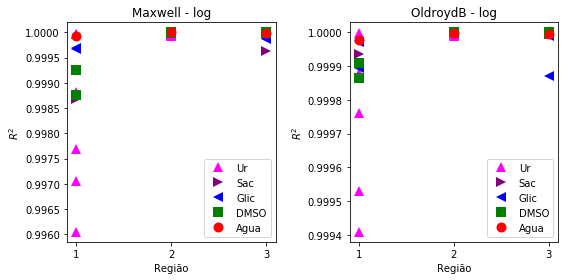

In [84]:
ptos_maxwell = pd.read_csv('ajustes_pontos_manual_Maxwell_log_sem_13BD.txt', sep=';', encoding='utf8')
ptos_oldroyd = pd.read_csv('ajustes_pontos_manual_Oldroyd_log_sem_13BD.txt', sep=';', encoding='utf8')

nomes = ['Agua', 'DMSO', 'Glic', 'Sac', 'Ur']
cores = ['red', 'green', 'blue', 'purple', 'magenta']
simbolos = ['o', 's', '<', '>', '^']

nomes.reverse()

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
MARKERSIZE=10

for nome in nomes:
    maxwell_int_1 = ptos_maxwell[ptos_maxwell['nome'].str.endswith('1') & ptos_maxwell['nome'].str.contains(nome)]
    maxwell_int_2 = ptos_maxwell[ptos_maxwell['nome'].str.endswith('2') & ptos_maxwell['nome'].str.contains(nome)]
    maxwell_int_3 = ptos_maxwell[ptos_maxwell['nome'].str.endswith('3') & ptos_maxwell['nome'].str.contains(nome)]

    lst1 = ['1'] * len(maxwell_int_1)
    lst2 = ['2'] * len(maxwell_int_2)
    lst3 = ['3'] * len(maxwell_int_3)

    oldroyd_int_1 = ptos_oldroyd[ptos_oldroyd['nome'].str.endswith('1') & ptos_oldroyd['nome'].str.contains(nome)]
    oldroyd_int_2 = ptos_oldroyd[ptos_oldroyd['nome'].str.endswith('2') & ptos_oldroyd['nome'].str.contains(nome)]
    oldroyd_int_3 = ptos_oldroyd[ptos_oldroyd['nome'].str.endswith('3') & ptos_oldroyd['nome'].str.contains(nome)]

    lst1 = ['1'] * len(oldroyd_int_1)
    lst2 = ['2'] * len(oldroyd_int_2)
    lst3 = ['3'] * len(oldroyd_int_3)

    cor = cores.pop()
    simbolo = simbolos.pop()
    
    ax1.plot(lst1, maxwell_int_1['r2'], linewidth=0, markersize=MARKERSIZE, 
         markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
    ax1.plot(lst2, maxwell_int_2['r2'], linewidth=0, markersize=MARKERSIZE, 
         markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
    ax1.plot(lst3, maxwell_int_3['r2'], linewidth=0, markersize=MARKERSIZE, 
         markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)  

    ax1.set_ylabel('$R^2$')
    ax1.set_xlabel('Região')
    ax1.set_title('Maxwell - log')
    
    ax2.plot(lst1, oldroyd_int_1['r2'], linewidth=0, markersize=MARKERSIZE, 
             markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
    ax2.plot(lst2, oldroyd_int_2['r2'], linewidth=0, markersize=MARKERSIZE,
             markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
    ax2.plot(lst3, oldroyd_int_3['r2'], linewidth=0, markersize=MARKERSIZE,
             markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
    ax2.set_ylabel('$R^2$')
    ax2.set_xlabel('Região')
    ax2.set_title('OldroydB - log')

lines_ax1 = list(ax1.get_lines())
lines_ax2 = list(ax2.get_lines())


ax1.legend(lines_ax1[::3], nomes)
ax2.legend(lines_ax2[::3], nomes)
fig.tight_layout()
fig.savefig('R2 das regiões 1, 2 e 3 com nomes escala log', dpi=300)

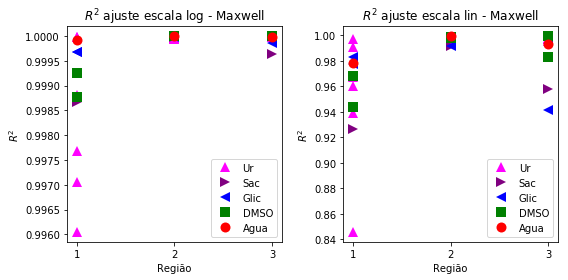

In [85]:
ptos_log = pd.read_csv('ajustes_pontos_manual_Maxwell_log_sem_13BD.txt', sep=';', encoding='utf8')
ptos_normal = pd.read_csv('ajustes_pontos_manual_Maxwell_sem_13BD.txt', sep=';', encoding='utf8')

nomes = ['Agua', 'DMSO', 'Glic', 'Sac', 'Ur']
cores = ['red', 'green', 'blue', 'purple', 'magenta']
simbolos = ['o', 's', '<', '>', '^']

nomes.reverse()

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
MARKERSIZE=10

for nome in nomes:
    log_int_1 = ptos_log[ptos_log['nome'].str.endswith('1') & ptos_log['nome'].str.contains(nome)]
    log_int_2 = ptos_log[ptos_log['nome'].str.endswith('2') & ptos_log['nome'].str.contains(nome)]
    log_int_3 = ptos_log[ptos_log['nome'].str.endswith('3') & ptos_log['nome'].str.contains(nome)]

    lst1 = ['1'] * len(log_int_1)
    lst2 = ['2'] * len(log_int_2)
    lst3 = ['3'] * len(log_int_3)

    normal_int_1 = ptos_normal[ptos_normal['nome'].str.endswith('1') & ptos_normal['nome'].str.contains(nome)]
    normal_int_2 = ptos_normal[ptos_normal['nome'].str.endswith('2') & ptos_normal['nome'].str.contains(nome)]
    normal_int_3 = ptos_normal[ptos_normal['nome'].str.endswith('3') & ptos_normal['nome'].str.contains(nome)]

    lst1 = ['1'] * len(normal_int_1)
    lst2 = ['2'] * len(normal_int_2)
    lst3 = ['3'] * len(normal_int_3)

    cor = cores.pop()
    simbolo = simbolos.pop()
    
    ax1.plot(lst1, log_int_1['r2'], linewidth=0, markersize=MARKERSIZE, 
         markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
    ax1.plot(lst2, log_int_2['r2'], linewidth=0, markersize=MARKERSIZE, 
         markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
    ax1.plot(lst3, log_int_3['r2'], linewidth=0, markersize=MARKERSIZE, 
         markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)  

    ax1.set_ylabel('$R^2$')
    ax1.set_xlabel('Região')
    ax1.set_title('$R^2$ ajuste escala log - Maxwell')
    
    ax2.plot(lst1, normal_int_1['r2'], linewidth=0, markersize=MARKERSIZE, 
             markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
    ax2.plot(lst2, normal_int_2['r2'], linewidth=0, markersize=MARKERSIZE,
             markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
    ax2.plot(lst3, normal_int_3['r2'], linewidth=0, markersize=MARKERSIZE,
             markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
    ax2.set_ylabel('$R^2$')
    ax2.set_xlabel('Região')
    ax2.set_title('$R^2$ ajuste escala lin - Maxwell')

lines_ax1 = list(ax1.get_lines())
lines_ax2 = list(ax2.get_lines())


ax1.legend(lines_ax1[::3], nomes)
ax2.legend(lines_ax2[::3], nomes)
fig.tight_layout()
fig.savefig('R2 log linear Maxwell.png', dpi=300)

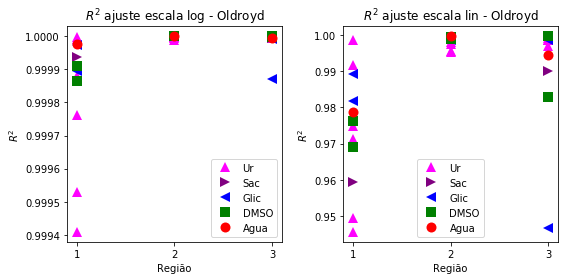

In [86]:
ptos_log = pd.read_csv('ajustes_pontos_manual_Oldroyd_log_sem_13BD.txt', sep=';', encoding='utf8')
ptos_normal = pd.read_csv('ajustes_pontos_manual_Oldroyd_sem_13BD.txt', sep=';', encoding='utf8')

nomes = ['Agua', 'DMSO', 'Glic', 'Sac', 'Ur']
cores = ['red', 'green', 'blue', 'purple', 'magenta']
simbolos = ['o', 's', '<', '>', '^']

nomes.reverse()

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
MARKERSIZE=10

for nome in nomes:
    log_int_1 = ptos_log[ptos_log['nome'].str.endswith('1') & ptos_log['nome'].str.contains(nome)]
    log_int_2 = ptos_log[ptos_log['nome'].str.endswith('2') & ptos_log['nome'].str.contains(nome)]
    log_int_3 = ptos_log[ptos_log['nome'].str.endswith('3') & ptos_log['nome'].str.contains(nome)]

    lst1 = ['1'] * len(log_int_1)
    lst2 = ['2'] * len(log_int_2)
    lst3 = ['3'] * len(log_int_3)

    normal_int_1 = ptos_normal[ptos_normal['nome'].str.endswith('1') & ptos_normal['nome'].str.contains(nome)]
    normal_int_2 = ptos_normal[ptos_normal['nome'].str.endswith('2') & ptos_normal['nome'].str.contains(nome)]
    normal_int_3 = ptos_normal[ptos_normal['nome'].str.endswith('3') & ptos_normal['nome'].str.contains(nome)]

    lst1 = ['1'] * len(normal_int_1)
    lst2 = ['2'] * len(normal_int_2)
    lst3 = ['3'] * len(normal_int_3)

    cor = cores.pop()
    simbolo = simbolos.pop()
    
    ax1.plot(lst1, log_int_1['r2'], linewidth=0, markersize=MARKERSIZE, 
         markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
    ax1.plot(lst2, log_int_2['r2'], linewidth=0, markersize=MARKERSIZE, 
         markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
    ax1.plot(lst3, log_int_3['r2'], linewidth=0, markersize=MARKERSIZE, 
         markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)  

    ax1.set_ylabel('$R^2$')
    ax1.set_xlabel('Região')
    ax1.set_title('$R^2$ ajuste escala log - Oldroyd')
    
    ax2.plot(lst1, normal_int_1['r2'], linewidth=0, markersize=MARKERSIZE, 
             markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
    ax2.plot(lst2, normal_int_2['r2'], linewidth=0, markersize=MARKERSIZE,
             markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
    ax2.plot(lst3, normal_int_3['r2'], linewidth=0, markersize=MARKERSIZE,
             markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
    ax2.set_ylabel('$R^2$')
    ax2.set_xlabel('Região')
    ax2.set_title('$R^2$ ajuste escala lin - Oldroyd')

lines_ax1 = list(ax1.get_lines())
lines_ax2 = list(ax2.get_lines())


ax1.legend(lines_ax1[::3], nomes)
ax2.legend(lines_ax2[::3], nomes)
fig.tight_layout()
fig.savefig('R2 log linear Oldroyd.png', dpi=300)

## Relação entre $R^2$ e $\tau_R$

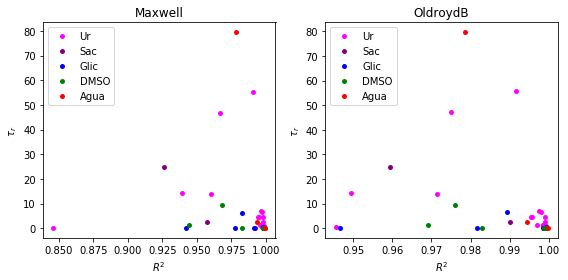

In [90]:
ptos_maxwell = pd.read_csv('ajustes_pontos_manual_Maxwell_sem_13BD.txt', sep=';', encoding='utf8').sort_values('tau_r')
ptos_oldroyd = pd.read_csv('ajustes_pontos_manual_Oldroyd_sem_13BD.txt', sep=';', encoding='utf8').sort_values('tau_r')

nomes = ['Agua', 'DMSO', 'Glic', 'Sac', 'Ur']
cores = ['red', 'green', 'blue', 'purple', 'magenta']
simbolos = ['o', 's', '<', '>', '^']

nomes.reverse()

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
MARKERSIZE=10

for nome in nomes:
    cor = cores.pop()
    maxwell_r2 = ptos_maxwell[ptos_maxwell['nome'].str.contains(nome)]['r2']
    maxwell_taur = ptos_maxwell[ptos_maxwell['nome'].str.contains(nome)]['tau_r']
    ax1.plot(maxwell_r2, maxwell_taur, linewidth=0, marker='o', markersize=5, 
             markerfacecolor=cor, markeredgewidth=0, label=nome)
    
    oldroyd_r2 = ptos_oldroyd[ptos_oldroyd['nome'].str.contains(nome)]['r2']
    oldroyd_taur = ptos_oldroyd[ptos_oldroyd['nome'].str.contains(nome)]['tau_r']
    ax2.plot(oldroyd_r2, oldroyd_taur, linewidth=0, marker='o', markersize=5, 
             markerfacecolor=cor, markeredgewidth=0, label=nome)
    
    ax1.set_xlabel('$R^2$')
    ax2.set_xlabel('$R^2$')
    ax1.set_ylabel(r'$\tau_r$')
    ax2.set_ylabel(r'$\tau_r$')
    ax1.set_title('Maxwell')
    ax2.set_title('OldroydB')
    
ax1.legend()
ax2.legend()
fig.tight_layout()
fig.savefig('R2 em fc tr Maxwell Oldroyd.png', dpi=300)

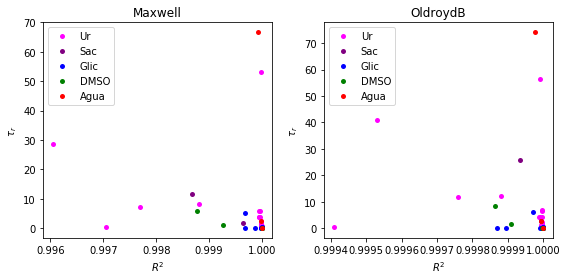

In [89]:
ptos_maxwell = pd.read_csv('ajustes_pontos_manual_Maxwell_log_sem_13BD.txt', sep=';', encoding='utf8').sort_values('tau_r')
ptos_oldroyd = pd.read_csv('ajustes_pontos_manual_Oldroyd_log_sem_13BD.txt', sep=';', encoding='utf8').sort_values('tau_r')

nomes = ['Agua', 'DMSO', 'Glic', 'Sac', 'Ur']
cores = ['red', 'green', 'blue', 'purple', 'magenta']
simbolos = ['o', 's', '<', '>', '^']

nomes.reverse()

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
MARKERSIZE=10

for nome in nomes:
    cor = cores.pop()
    maxwell_r2 = ptos_maxwell[ptos_maxwell['nome'].str.contains(nome)]['r2']
    maxwell_taur = ptos_maxwell[ptos_maxwell['nome'].str.contains(nome)]['tau_r']
    ax1.plot(maxwell_r2, maxwell_taur, linewidth=0, marker='o', markersize=5, 
             markerfacecolor=cor, markeredgewidth=0, label=nome)
    
    oldroyd_r2 = ptos_oldroyd[ptos_oldroyd['nome'].str.contains(nome)]['r2']
    oldroyd_taur = ptos_oldroyd[ptos_oldroyd['nome'].str.contains(nome)]['tau_r']
    ax2.plot(oldroyd_r2, oldroyd_taur, linewidth=0, marker='o', markersize=5, 
             markerfacecolor=cor, markeredgewidth=0, label=nome)
    
    ax1.set_xlabel('$R^2$')
    ax2.set_xlabel('$R^2$')
    ax1.set_ylabel(r'$\tau_r$')
    ax2.set_ylabel(r'$\tau_r$')
    ax1.set_title('Maxwell')
    ax2.set_title('OldroydB')
    
ax1.legend()
ax2.legend()
fig.tight_layout()
fig.savefig('R2 em fc tr Maxwell Oldroyd log.png', dpi=300)

### Comparando os parâmetros de ajuste dos dois ajustes

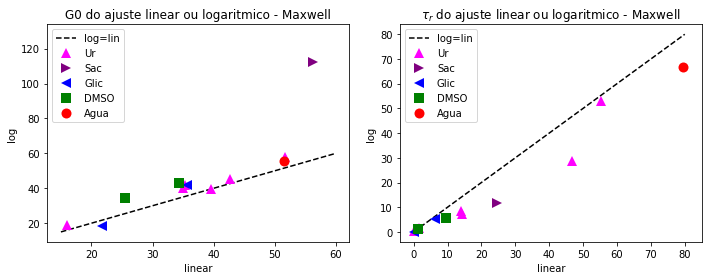

In [109]:
ptos_log = pd.read_csv('ajustes_pontos_manual_Maxwell_log_sem_13BD.txt', sep=';', encoding='utf8')
ptos_normal = pd.read_csv('ajustes_pontos_manual_Maxwell_sem_13BD.txt', sep=';', encoding='utf8')

nomes = ['Agua', 'DMSO', 'Glic', 'Sac', 'Ur']
cores = ['red', 'green', 'blue', 'purple', 'magenta']
simbolos = ['o', 's', '<', '>', '^']

nomes.reverse()

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
MARKERSIZE=10

for nome in nomes:
    log_int_1 = ptos_log[ptos_log['nome'].str.endswith('1') & ptos_log['nome'].str.contains(nome)]

#     lst1 = ['1'] * len(log_int_1)
#     lst2 = ['2'] * len(log_int_2)
#     lst3 = ['3'] * len(log_int_3)

    normal_int_1 = ptos_normal[ptos_normal['nome'].str.endswith('1') & ptos_normal['nome'].str.contains(nome)]

#     lst1 = ['1'] * len(normal_int_1)
#     lst2 = ['2'] * len(normal_int_2)
#     lst3 = ['3'] * len(normal_int_3)

    cor = cores.pop()
    simbolo = simbolos.pop()
    
#     ax1.plot(normal_int_1['G0'], log_int_1['G0'], linewidth=0, markersize=MARKERSIZE, 
#          markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
    ax1.errorbar(normal_int_1['G0'], log_int_1['G0'], xerr=normal_int_1['G0_err'], yerr=log_int_1['G0_err'],
                 linewidth=0, markersize=MARKERSIZE, markerfacecolor=cor, markeredgecolor=cor, 
                 marker=simbolo, label=nome, markeredgewidth=0)
    

    ax1.set_ylabel('log')
    ax1.set_xlabel('linear')
    ax1.set_title('G0 do ajuste linear ou logaritmico - Maxwell')
    
    ax2.errorbar(normal_int_1['tau_r'], log_int_1['tau_r'], xerr=normal_int_1['tau_r_err'], yerr=log_int_1['tau_r_err'],
                 linewidth=0, markersize=MARKERSIZE, markerfacecolor=cor, markeredgecolor=cor, 
                 marker=simbolo, label=nome, markeredgewidth=0)
    

    ax2.set_ylabel('log')
    ax2.set_xlabel('linear')
    ax2.set_title(r'$\tau_r$ do ajuste linear ou logaritmico - Maxwell')
#     ax2.plot(lst1, normal_int_1['r2'], linewidth=0, markersize=MARKERSIZE, 
#              markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
#     ax2.plot(lst2, normal_int_2['r2'], linewidth=0, markersize=MARKERSIZE,
#              markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
#     ax2.plot(lst3, normal_int_3['r2'], linewidth=0, markersize=MARKERSIZE,
#              markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
#     ax2.set_ylabel('$R^2$')
#     ax2.set_xlabel('Região')
#     ax2.set_title('$R^2$ ajuste escala lin - Maxwell')

ax1.plot(np.linspace(15, 60), np.linspace(15, 60), 'k--', label='log=lin')
ax2.plot(np.linspace(0, 80), np.linspace(0, 80), 'k--', label='log=lin')
ax1.legend()
ax2.legend()


# ax1.legend(lines_ax1[::3], nomes)
# ax2.legend(lines_ax2[::3], nomes)
fig.tight_layout()
fig.savefig('G0 tr lin e log Maxwell.png', dpi=300)

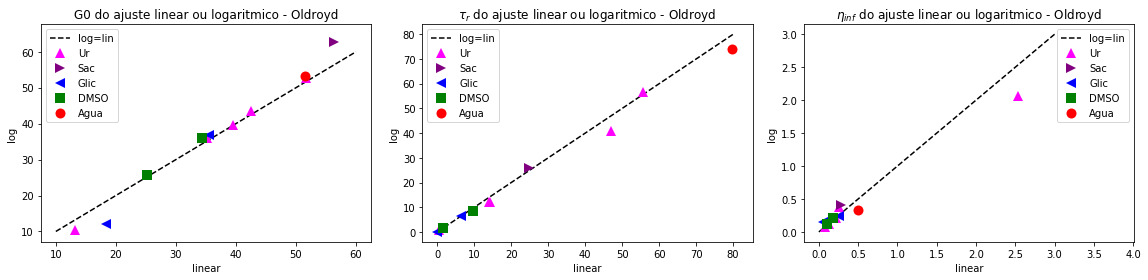

In [114]:
ptos_log = pd.read_csv('ajustes_pontos_manual_Oldroyd_log_sem_13BD.txt', sep=';', encoding='utf8')
ptos_normal = pd.read_csv('ajustes_pontos_manual_Oldroyd_sem_13BD.txt', sep=';', encoding='utf8')

nomes = ['Agua', 'DMSO', 'Glic', 'Sac', 'Ur']
cores = ['red', 'green', 'blue', 'purple', 'magenta']
simbolos = ['o', 's', '<', '>', '^']

nomes.reverse()

fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
MARKERSIZE=10

for nome in nomes:
    log_int_1 = ptos_log[ptos_log['nome'].str.endswith('1') & ptos_log['nome'].str.contains(nome)]

#     lst1 = ['1'] * len(log_int_1)
#     lst2 = ['2'] * len(log_int_2)
#     lst3 = ['3'] * len(log_int_3)

    normal_int_1 = ptos_normal[ptos_normal['nome'].str.endswith('1') & ptos_normal['nome'].str.contains(nome)]

#     lst1 = ['1'] * len(normal_int_1)
#     lst2 = ['2'] * len(normal_int_2)
#     lst3 = ['3'] * len(normal_int_3)

    cor = cores.pop()
    simbolo = simbolos.pop()
    
#     ax1.plot(normal_int_1['G0'], log_int_1['G0'], linewidth=0, markersize=MARKERSIZE, 
#          markerfacecolor=cor, markeredgecolor=cor, marker=simbolo, label=nome, markeredgewidth=0)
    ax1.errorbar(normal_int_1['G0'], log_int_1['G0'], xerr=normal_int_1['G0_err'], yerr=log_int_1['G0_err'],
                 linewidth=0, markersize=MARKERSIZE, markerfacecolor=cor, markeredgecolor=cor, 
                 marker=simbolo, label=nome, markeredgewidth=0)
    

    ax1.set_ylabel('log')
    ax1.set_xlabel('linear')
    ax1.set_title('G0 do ajuste linear ou logaritmico - Oldroyd')
    
    ax2.errorbar(normal_int_1['tau_r'], log_int_1['tau_r'], xerr=normal_int_1['tau_r_err'], yerr=log_int_1['tau_r_err'],
                 linewidth=0, markersize=MARKERSIZE, markerfacecolor=cor, markeredgecolor=cor, 
                 marker=simbolo, label=nome, markeredgewidth=0)
    

    ax2.set_ylabel('log')
    ax2.set_xlabel('linear')
    ax2.set_title(r'$\tau_r$ do ajuste linear ou logaritmico - Oldroyd')
    
    ax3.errorbar(normal_int_1['eta_inf'], log_int_1['eta_inf'], xerr=normal_int_1['eta_inf_err'], yerr=log_int_1['eta_inf_err'],
                 linewidth=0, markersize=MARKERSIZE, markerfacecolor=cor, markeredgecolor=cor, 
                 marker=simbolo, label=nome, markeredgewidth=0)
    

    ax3.set_ylabel('log')
    ax3.set_xlabel('linear')
    ax3.set_title(r'$\eta_{inf}$ do ajuste linear ou logaritmico - Oldroyd')


ax1.plot(np.linspace(10, 60), np.linspace(10, 60), 'k--', label='log=lin')
ax2.plot(np.linspace(0, 80), np.linspace(0, 80), 'k--', label='log=lin')
ax3.plot(np.linspace(0, 3), np.linspace(0, 3), 'k--', label='log=lin')

ax1.legend()
ax2.legend()
ax3.legend()


# ax1.legend(lines_ax1[::3], nomes)
# ax2.legend(lines_ax2[::3], nomes)
fig.tight_layout()
fig.savefig('G0 tr etainf lin e log Oldroyd.png', dpi=300)

### Contagem de casos onde os parametros do log são maiores que o lin

#### Maxwell

In [155]:
ptos_log = pd.read_csv('ajustes_pontos_manual_Maxwell_log_sem_13BD.txt', sep=';', encoding='utf8')
ptos_normal = pd.read_csv('ajustes_pontos_manual_Maxwell_sem_13BD.txt', sep=';', encoding='utf8')

G0_log_maior_lin = sum(ptos_log['G0'] > ptos_normal['G0']) / len(ptos_log) * 100 # 70
tr_log_maior_lin = sum(ptos_log['tau_r'] > ptos_normal['tau_r']) / len(ptos_log) * 100 # 61

G0_log_vezes_maior_lin = np.mean(ptos_log['G0'] / ptos_normal['G0'])
G0_log_vezes_maior_lin_err = np.std(ptos_log['G0'] / ptos_normal['G0'])
tr_log_vezes_maior_lin = np.mean(ptos_log['tau_r'] / ptos_normal['tau_r'])
tr_log_vezes_maior_lin_err = np.std(ptos_log['tau_r'] / ptos_normal['tau_r'])

print(G0_log_maior_lin, tr_log_maior_lin, '\n',
      G0_log_vezes_maior_lin, G0_log_vezes_maior_lin_err, '\n', 
      tr_log_vezes_maior_lin, tr_log_vezes_maior_lin_err, '\n')

91.66666666666666 22.22222222222222 
 1.1266474389392842 0.17806811173015527 
 0.929464104737846 0.24974834324890316 



#### Oldroyd

In [154]:
ptos_log = pd.read_csv('ajustes_pontos_manual_Oldroyd_log_sem_13BD.txt', sep=';', encoding='utf8')
ptos_normal = pd.read_csv('ajustes_pontos_manual_Oldroyd_sem_13BD.txt', sep=';', encoding='utf8')

G0_log_maior_lin = sum(ptos_log['G0'] > ptos_normal['G0']) / len(ptos_log) * 100 # 70
tr_log_maior_lin = sum(ptos_log['tau_r'] > ptos_normal['tau_r']) / len(ptos_log) * 100 # 61
eta_inf_maior_lin = sum(ptos_log['eta_inf'] > ptos_normal['eta_inf']) / len(ptos_log) * 100 # 44

G0_log_vezes_maior_lin = np.mean(ptos_log['G0'] / ptos_normal['G0'])
G0_log_vezes_maior_lin_err = np.std(ptos_log['G0'] / ptos_normal['G0'])
tr_log_vezes_maior_lin = np.mean(ptos_log['tau_r'] / ptos_normal['tau_r'])
tr_log_vezes_maior_lin_err = np.std(ptos_log['tau_r'] / ptos_normal['tau_r'])
eta_log_vezes_maior_lin = np.mean(ptos_log[ptos_log['eta_inf'] > 0.0001]['eta_inf']  / ptos_normal[ptos_normal['eta_inf'] > 0.0001]['eta_inf'] )
eta_log_vezes_maior_lin_err = np.std(ptos_log[ptos_log['eta_inf'] > 0.0001]['eta_inf']  / ptos_normal[ptos_normal['eta_inf'] > 0.0001]['eta_inf'])

print(G0_log_maior_lin, tr_log_maior_lin, eta_inf_maior_lin, '\n', 
      G0_log_vezes_maior_lin, G0_log_vezes_maior_lin_err, '\n', 
      tr_log_vezes_maior_lin, tr_log_vezes_maior_lin_err, '\n',
      eta_log_vezes_maior_lin, eta_log_vezes_maior_lin_err)

69.44444444444444 61.111111111111114 44.44444444444444 
 1.0010929958088441 0.07604820585702167 
 1.039851934933659 0.18605784506236694 
 1.0570120851532792 0.3535428428025204


## Algumas curvas não fitaram direito, ficaram deslocadas.
### Será que outros modelos funcionam melhor?
* DMSO25-1
* Sac50-1
* Água1

In [34]:
pontos_pd = pd.read_csv('ajustes_pontos_manual_Maxwell.txt', encoding='utf8', sep=';')

ponto_ag = pontos_pd[pontos_pd['nome'] == 'Agua1']['pto_final']
ponto_dmso = pontos_pd[pontos_pd['nome'] == 'DMSO25-1']['pto_final']
ponto_sac = pontos_pd[pontos_pd['nome'] == 'Sac50-1']['pto_final']

ptos = [ponto_ag.values[0], ponto_dmso.values[0], ponto_sac.values[0]]
ptos

[36, 25, 36]

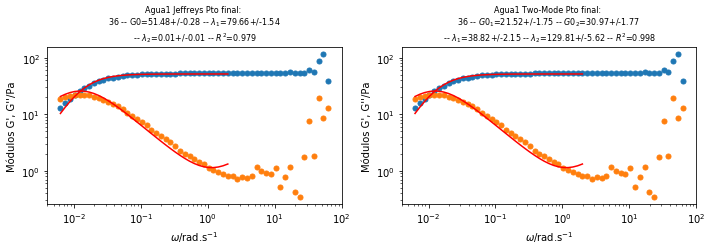

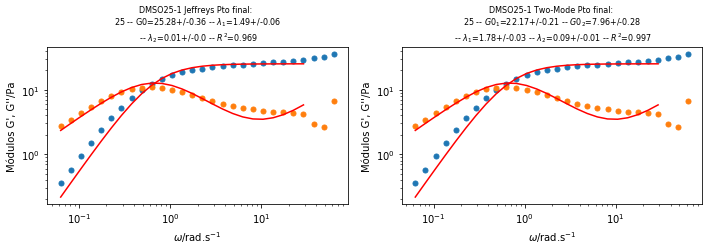

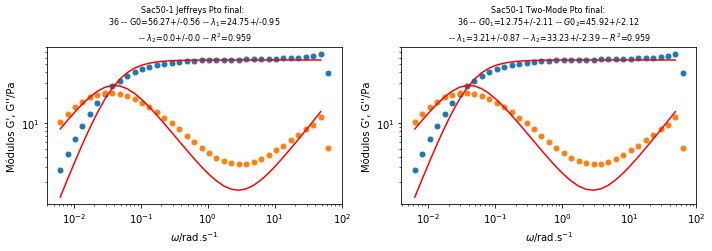

In [46]:


files = [i for i in glob.glob('*.csv') if ('DMSO25-1' in i) or ('Sac50-1' in i) or ('Agua1' in i)]
files_pd = []

for file in files:
    temp_pd = pd.read_csv(file, encoding='utf8', delimiter=';', decimal=',')
    files_pd.append(temp_pd)
    
for i, file in enumerate(files_pd):
    wnum = 0
    G1num = 0
    G2num = 0
    
    wname = ''
    G1name = ''
    G2name = ''
    for j, col in enumerate(file.columns):
        if 'w' in col:
            wnum = j
            wname = col
        elif 'G1' in col:
            G1num = j
            G1name = col
        elif 'G2' in col:
            G2num = j
            G2name = col
    
    final = ptos[i]
    dataset_x = file[wname][:final]
    dataset_elast = file[G1name][:final]
    dataset_visc = file[G2name][:final]
    datasets = [dataset_elast, dataset_visc]
    
    name = G1name.split(' ')[0]
    

# def residual_jeffreys(params, x, datasets):
#     jeff_elast = jeffreys_elast2(x, params['G0'], params['lambda1'], params['lambda2'])
#     jeff_visc  = jeffreys_visc2 (x, params['G0'], params['lambda1'], params['lambda2'])

#     resid1 = datasets[0] - jeff_elast
#     resid2 = datasets[1] - jeff_visc
#     return np.concatenate((resid1, resid2))

# def residual_two_mode(params, x, datasets):
#     tm_elast = two_mode_elast(x, params['G0_1'], params['G0_2'], params['lambda1'], params['lambda2'])
#     tm_visc  = two_mode_visc (x, params['G0_1'], params['G0_2'], params['lambda1'], params['lambda2'])

#     resid1 = datasets[0] - tm_elast
#     resid2 = datasets[1] - tm_visc
#     return np.concatenate((resid1, resid2))
    
    fig, [ax1, ax2] = plt.subplots(ncols=2, nrows=1, figsize=(10,3.6))
    
    ###################
    # Fit Jeffreys
    params = Parameters()
    params.add('G0',          10., vary=True, min=0)
    params.add('lambda1',          1. , vary=True, min=0)
    params.add('lambda2',          1 , vary=True, min=0)

    fit_j = minimize( residual_jeffreys, params, args=(dataset_x, datasets) )

    jeff_G0_fit = fit_j.params['G0']
    jeff_lambda0_fit = fit_j.params['lambda1']
    jeff_lambdaj_fit = fit_j.params['lambda2']
    
    j_elast = jeffreys_elast2(dataset_x, jeff_G0_fit, jeff_lambda0_fit, jeff_lambdaj_fit)
    j_visc = jeffreys_visc2(dataset_x, jeff_G0_fit, jeff_lambda0_fit, jeff_lambdaj_fit)

    SStot_elast = sum((dataset_elast - np.mean(dataset_elast)) ** 2)
    SStot_visc = sum((dataset_visc - np.mean(dataset_visc)) ** 2)
    SSres = fit_j.chisqr
    SStot = SStot_elast + SStot_visc
    j_R2 = 1 - SSres / SStot
    
    ax1.plot(file[wname], file[G1name], linewidth=0, marker='o', markersize=5)
    ax1.plot(file[wname], file[G2name], linewidth=0, marker='o', markersize=5)
    ax1.plot(dataset_x, j_elast, c='red')
    ax1.plot(dataset_x, j_visc, c='red')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_xlabel(r'$\omega$/rad.s$^{-1}$')
    ax1.set_ylabel("Módulos G', G''/Pa")
    ax1.set_title(
          name + ' Jeffreys Pto final: \n' + str(final) +
          ' -- G0=' + str(round(jeff_G0_fit.value,2)) + '+/-' + str(round(jeff_G0_fit.stderr,2)) +
          r' -- $\lambda_1$=' + str(round(jeff_lambda0_fit.value,2)) + '+/-' + str(round(jeff_lambda0_fit.stderr,2)) + 
          '\n' + 
          r' -- $\lambda_2$=' + str(round(jeff_lambdaj_fit.value,2)) + '+/-' + str(round(jeff_lambdaj_fit.stderr,2)) + 
          ' -- $R^2$=' + str(round(j_R2, 3)), fontsize=8
         )
    
    with open(os.path.join('ajustes extras', 'ajustes_pontos_jeff.txt'), 'a') as fhand:
        fhand.write(name + ';' + 
               str(final) + ';' + 
               str(jeff_G0_fit.value) + ';' +  str(jeff_G0_fit.stderr) + ';' + 
               str(jeff_lambda0_fit.value) + ';' + str(jeff_lambda0_fit.stderr) + ';' +
               str(jeff_lambdaj_fit.value) + ';' + str(jeff_lambdaj_fit.stderr) + ';' + 
               str(j_R2) + '\n')
    
    # Fit Two Mode
    params = Parameters()
    params.add('G0_1',          10., vary=True, min=0)
    params.add('lambda1',          1. , vary=True, min=0)
    params.add('G0_2',          10., vary=True, min=0)
    params.add('lambda2',          1. , vary=True, min=0)

    tm_fit = minimize( residual_two_mode, params, args=(dataset_x, datasets) )

    G01_fit = tm_fit.params['G0_1']
    tr1_fit = tm_fit.params['lambda1']
    G02_fit = tm_fit.params['G0_2']
    tr2_fit = tm_fit.params['lambda2']
    
    tm_elast = two_mode_elast(dataset_x, G01_fit, G02_fit, tr1_fit, tr2_fit)
    tm_visc = two_mode_visc(dataset_x, G01_fit, G02_fit, tr1_fit, tr2_fit)

    SStot_elast = sum((dataset_elast - np.mean(dataset_elast)) ** 2)
    SStot_visc = sum((dataset_visc - np.mean(dataset_visc)) ** 2)
    SSres = tm_fit.chisqr
    SStot = SStot_elast + SStot_visc
    tm_R2 = 1 - SSres / SStot
    
    ax2.plot(file[wname], file[G1name], linewidth=0, marker='o', markersize=5)
    ax2.plot(file[wname], file[G2name], linewidth=0, marker='o', markersize=5)
    ax2.plot(dataset_x, j_elast, c='red')
    ax2.plot(dataset_x, j_visc, c='red')
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.set_xlabel(r'$\omega$/rad.s$^{-1}$')
    ax2.set_ylabel("Módulos G', G''/Pa")
    ax2.set_title(
          name + ' Two-Mode Pto final: \n' + str(final) +
          ' -- $G0_1$=' + str(round(G01_fit.value,2)) + '+/-' + str(round(G01_fit.stderr,2)) +
          ' -- $G0_2$=' + str(round(G02_fit.value,2)) + '+/-' + str(round(G02_fit.stderr,2)) +
          '\n' + 
          r' -- $\lambda_1$=' + str(round(tr1_fit.value,2)) + '+/-' + str(round(tr1_fit.stderr,2)) + 
          r' -- $\lambda_2$=' + str(round(tr2_fit.value,2)) + '+/-' + str(round(tr2_fit.stderr,2)) + 
          ' -- $R^2$=' + str(round(tm_R2, 3)), fontsize=8
         )

    with open(os.path.join('ajustes extras', 'ajustes_pontos_tm.txt'), 'a') as fhand:
        fhand.write(name + ';' + 
           str(final) + ';' + 
           str(G01_fit.value) + ';' +  str(G01_fit.stderr) + ';' + 
           str(G02_fit.value) + ';' + str(G02_fit.stderr) + ';' +
           str(tr1_fit.value) + ';' + str(tr1_fit.stderr) + ';' + 
           str(tr2_fit.value) + ';' + str(tr2_fit.stderr) + ';' + 
           str(tm_R2) + '\n')
    
    ###########
    fig.tight_layout()


    destpath = os.path.join('ajustes extras', name + '.png')
    counter = 0
    while os.path.isfile(destpath):
        counter += 1
        destpath = os.path.join('ajustes extras', name + '--' + str(counter) + '.png')
    plt.savefig(destpath, dpi=300)

In [27]:
report_fit(fit_j)

[[Fit Statistics]]
    # function evals   = 46
    # data points      = 72
    # variables        = 3
    chi-square         = 577.385
    reduced chi-square = 8.368
    Akaike info crit   = 155.893
    Bayesian info crit = 162.723
[[Variables]]
    G0:        56.2728988 +/- 0.564498 (1.00%) (init= 10)
    lambda1:   24.7467778 +/- 0.951429 (3.84%) (init= 1)
    lambda2:   0.00499676 +/- 0.000671 (13.42%) (init= 1)
[[Correlations]] (unreported correlations are <  0.100)
    C(G0, lambda1)               = -0.262 
